In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os, sys
import copy
import healpy as hp
import numpy as np
from scipy.integrate import quad
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from matplotlib import rcParams
from tqdm import *
import iminuit
from iminuit import Minuit, describe, Struct
from scipy.interpolate import interp1d
from scipy.optimize import minimize

sys.path.append("/tigress/somalwar/Subhaloes/Subhalos/Modules/")
sys.path.append("/tigress/somalwar/Subhaloes/Subhalos/")
# My Functions"
import AssortedFunctions
from AssortedFunctions import myLog
import InverseTransform
import PowerLaw

# Siddharth and Laura's Stuff
import constants_noh as constants
import units

# NPTFit modules
from NPTFit import nptfit # module for performing scan
from NPTFit import create_mask as cm # module for creating the mask
from NPTFit import psf_correction as pc # module for determining the PSF correction
from NPTFit import dnds_analysis
rcParams['font.size'] = 15
rcParams['text.usetex'] = True

In [2]:
# Global settings
nside=128
emin = 0
emax = 39

In [45]:
trials = 100
channel = 'b'
ebins = 2*np.logspace(-1,3,41)[emin:emax+2]
my_iebins = [20, 40]
print(ebins[my_iebins])

[  20. 2000.]


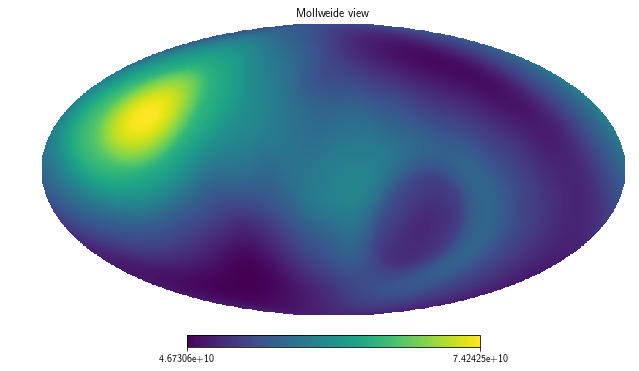

In [46]:
exposure_ebins= []
for ib, b in enumerate(my_iebins[:-1]):
    fermi_exposure = np.zeros(len(np.load("maps/exposure0.npy")))
    n = 0
    for bin_ind in range(b, my_iebins[ib+1]):
        n+=1
        fermi_exposure += np.load("maps/exposure"+str(bin_ind)+".npy")
    fermi_exposure = fermi_exposure / n
    exposure_ebins.append(fermi_exposure)
hp.mollview(fermi_exposure)

In [47]:
# Setting basic parameters
nside = 128
npix = hp.nside2npix(nside)
   
pscmask=np.array(np.load('/tigress/somalwar/Subhaloes/Subhalos/fermi_data/fermidata_pscmask.npy'), dtype=bool)
mask = cm.make_mask_total(band_mask = True, band_mask_range = 5, mask_ring = True, inner = 20, outer = 180, custom_mask = pscmask)
area_rat = (len(mask[~mask]))/len(mask)

In [48]:
# Defining some constants
min_flux_arr = []
for exposure in exposure_ebins:
    min_flux_arr.append(np.log10(1./(np.sum(exposure[~mask])/len(exposure[~mask]))))

In [49]:
dNdF_file_ebins = []
cum_ebins = []
dNdF_func_ebins = []
N_blaz_ebins = []
for ib in range(len(my_iebins)-1):
    dNdF_file_ebins.append(np.load("/tigress/somalwar/Subhaloes/Subhalos/blazars/blazar_dNdF_"+str(my_iebins[ib])+"-"+str(my_iebins[ib+1])+".npy"))
    dNdF_file_ebins[-1] = [ dNdF_file_ebins[-1][0], dNdF_file_ebins[-1][1] ]
    dNdF_func_ebins.append(interp1d(dNdF_file_ebins[ib][0], dNdF_file_ebins[ib][1]))
    cum = []
    for i in range(len(dNdF_file_ebins[ib][0])):
        cum.append(np.trapz(dNdF_file_ebins[ib][1][:i+1], dNdF_file_ebins[ib][0][:i+1]))
    N_blaz_ebins.append(int(np.round(np.random.poisson(cum[-1]*area_rat*4*np.pi*(180/np.pi)**2))))
    cum = np.array(cum)/max(cum)
    cum_ebins.append(cum)

In [50]:
print((N_blaz_ebins))

[113868]


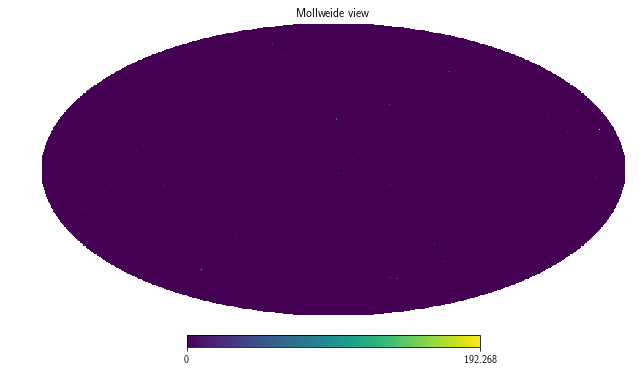

In [51]:
F_arr_ebins = []
F_arr_ebins2 = []
S_arr_ebins = []
#F_cons = 10**(-9.759519038076153)
F_cons = 10**(-3)
flux_bins = np.logspace(-14, -6, 56)
F_cut = flux_bins[np.argmin(np.abs(F_cons-flux_bins))]
for ib in range(len(my_iebins)-1):
    F_sampler = InverseTransform.InverseTransform(dNdF_func_ebins[ib], dNdF_file_ebins[ib][0], nsamples=N_blaz_ebins[ib], cdfinv=interp1d(cum_ebins[ib], dNdF_file_ebins[ib][0]))
    F_arr = []
    F_arr2 = []
    for i in tqdm_notebook(range(trials)):
        bmap_temp = np.zeros(hp.nside2npix(128))
        pval_arr = np.random.randint(len(bmap_temp), size=N_blaz_ebins[ib])
        Fval_arr = F_sampler.sample()
        pval_arr = pval_arr[Fval_arr < F_cut]
        Fval_arr = Fval_arr[Fval_arr < F_cut]
        Sval_arr = Fval_arr*exposure_ebins[ib][pval_arr]
        for ip, pval in enumerate(pval_arr):
            bmap_temp[pval] += Fval_arr[ip]
        if i == 0: hp.mollview(bmap_temp*exposure_ebins[ib])
        F_arr.append(np.histogram(Fval_arr[~mask[pval_arr]], bins=flux_bins)[0])
        Fval_arr[Fval_arr*exposure_ebins[ib][pval_arr] > 1000 ] = 0
        F_arr2.append(np.histogram(Fval_arr[~mask[pval_arr]], bins=flux_bins)[0])
        #np.save("blazarMC/blazar_map_test_"+str(my_iebins[ib])+"_"+str(my_iebins[ib+1])+"_"+str(i+20), bmap_temp)
    F_arr_ebins.append(F_arr)
    F_arr_ebins2.append(F_arr2)

In [52]:
min_flux_ind_arr = []
F_ave_arr = []
max_flux_arr = []
dF_arr = []
dN_arr = []
F_arr_arr = []
F_val_arr = []
for ib2 in range(2): #range(len(my_iebins)-1):
    ib = 0
    min_flux_ind_arr.append(np.argmin(np.abs(flux_bins - 10.**(min_flux_arr[ib]))))
    flux_bins2 = flux_bins[min_flux_ind_arr[-1]:]
    if ib == 0: F_arr = [np.array(F_arr_ebins[ib][-1]).astype(float)]
    if ib == 1: F_arr = [np.array(F_arr_ebins2[ib][-1]).astype(float)]
    #for i in range(len(F_arr)):
    #    F_arr[i][F_arr[i]<=1e-30] = 1e-50
    F_arr_arr.append(F_arr)
    F_ave_arr.append((np.median(F_arr, axis=0))[min_flux_ind_arr[-1]:])
    max_flux_arr.append(np.log10(flux_bins2[np.argmax(F_ave_arr[-1] < 1e-20)]))
    dF_arr.append(np.diff(flux_bins2))
    dN_arr.append(np.array(F_ave_arr[-1])/(4*np.pi*(180/np.pi)**2*area_rat))
    F_val_arr.append((np.array(flux_bins2)[:-1]+np.array(flux_bins2)[1:])/2.)

running
The number of parameters to be fit is 6


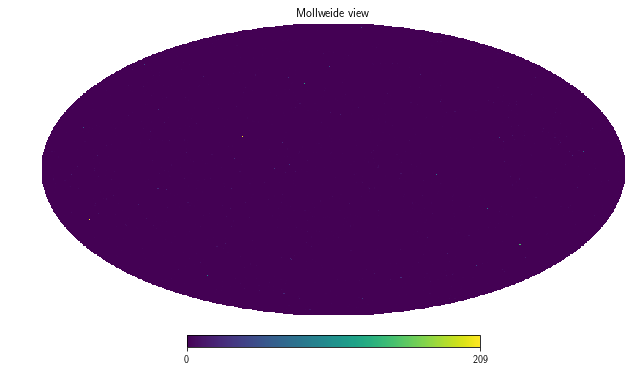

In [53]:
print("running")
best_fit_params = []
blaztemp = np.ones(hp.nside2npix(128))
for ib in range(len(my_iebins)-1):
    best_fit_params.append([])
    flux_map_ave = np.zeros(hp.nside2npix(nside))
    for t in range(1):
        flux_map = bmap_temp.copy() #np.load("blazarMC/blazar_map_nocut_"+str(my_iebins[ib])+"_"+str(my_iebins[ib+1])+"_"+str(t)+".npy")
        n = nptfit.NPTF(tag='fit')
        sig = np.round(flux_map * exposure_ebins[ib]).astype(np.int32)
        hp.mollview(sig)
        n.load_data(sig.copy(), exposure_ebins[ib].copy())
        n.load_mask(mask)
        
        subhalos_copy = blaztemp.copy()
        n.add_template(subhalos_copy, 'subhalos', units='PS')
        n.add_non_poiss_model( 'subhalos',
                              ['$A^\mathrm{ps}_\mathrm{iso}$','$n_1$','$n_2$', '$n_3$', '$S_b1$', '$S_b2$'],
                              [[-15, -2],[2.05, 10],[-3, 3],[-10, 1.95],[1,100], [0.1,1.]],
                              [True,False,False, False, False, False],
                              dnds_model='specify_relative_breaks' )

        n.configure_for_scan();
        def ll(args):
            A, n1, n2, n3, Fb1, Fb2 = args
            return -n.ll([A, n1, n2, n3, Fb1, Fb2])
#         minuit_min = iminuit.Minuit(ll, \
#                             A=-6, limit_A=(-10,-3), error_A=1e-2, \
#                             n1=10, limit_n1=(2.05, 3), error_n1=1e-2, \
#                             n2 = 0, limit_n2=(-3, 3), error_n2=1e-2, \
#                             n3 = 0.1, limit_n3=(-10, 0.95), error_n3=1e-2, \
#                             Fb1 = 60, limit_Fb1=(1, 100), error_Fb1=1e-2, \
#                             Fb2 = 0.5, limit_Fb2=(0.1, 1), error_Fb2=1e-3, \
#                             print_level=1);
    
#         minuit_min.migrad()
#         max_LL = -minuit_min.fval
        #scipy_min = minimize( ll, [-6, 5, 0, 0.1, 60, 0.5], method="SLSQP", bounds = [ [-10, -2], [2.05,10], [-5,5], [-10, 1.95], [1,100], [0.1, 1.] ], options={'ftol':1e-15, 'eps':1e-5, 'maxiter':50000, 'disp':True} )
        #best_fit_params[-1].append( np.array( [scipy_min.x[0], scipy_min.x[1], scipy_min.x[2], scipy_min.x[3], scipy_min.x[4], scipy_min.x[5] ]))
        #max_LL = -scipy_min.fun
        #best_fit_params[-1].append( np.array( [minuit_min.values['A'], minuit_min.values['n1'], minuit_min.values['n2'], minuit_min.values['n3'], minuit_min.values['Fb1'], minuit_min.values['Fb2'] ]))
        #best_fit_params[-1].append( np.array( [minuit_min.values['A'], minuit_min.values['n1'], minuit_min.values['n2'], minuit_min.values['Fb0'] ]))
        #print("Best Fit Params:", best_fit_params)
        #print("Max LL:", max_LL)

/tigress/somalwar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
/tigress/somalwar/Subhaloes/Subhalos/Modules/AssortedFunctions.py:20: RuntimeWarning: divide by zero encountered in log10
  return np.where( n!=0, np.log10(n), 0);


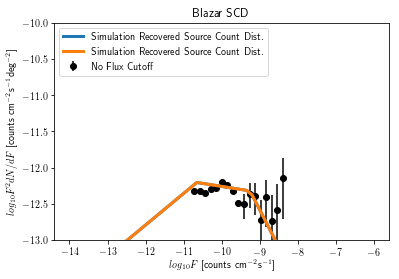

In [54]:
for ib, F_arr in enumerate(F_arr_arr):
    F_ave = F_ave_arr[ib]
    max_flux = max_flux_arr[0]
    min_flux = min_flux_arr[0]
    dF = dF_arr[ib]
    dN = dN_arr[ib]
    F = F_val_arr[ib]
    ib2 = ib
    ib = 0
    min_flux_ind = min_flux_ind_arr[ib]
    poisson = (trials==1)
    yerr_up = (AssortedFunctions.PandGErrors(F_arr, poisson))[1][min_flux_ind:]
    yerr_dn = (AssortedFunctions.PandGErrors(F_arr, poisson))[0][min_flux_ind:]
    yerr_up = F**2 * yerr_up / dF /(4*np.pi*(180/np.pi)**2*area_rat)
    yerr_dn = F**2 * yerr_dn / dF /(4*np.pi*(180/np.pi)**2*area_rat)
    dNdF_err = (yerr_up + yerr_dn)/2.
    delta_flux = np.log10(F_cons) - min_flux

    yerr_up = yerr_up/np.log(10) / (F**2 * dN/dF)
    yerr_dn = yerr_dn/np.log(10) / (F**2 * dN/dF)
    if ib2 == 0: plt.errorbar(myLog(F), myLog(F**2*dN/dF), yerr=[yerr_up, yerr_dn], fmt='o', c="black", label="No Flux Cutoff")
    #else: plt.errorbar(myLog(F), myLog(F**2*dN/dF), yerr=[yerr_up, yerr_dn], fmt='o', label="Flux Cutoff")
    #plt.plot(myLog(dNdF_file_ebins[ib][0]), myLog(dNdF_file_ebins[ib][0]**2*dNdF_file_ebins[ib][1]), label="Theory Source Count Dist.")
    
    for t in range(1):
        #best_fit_params2 = np.array([-6.20805300e+00, 10, -6.17462016e-03, 1.56432755e+00, 6.89171820e+02, 9.00000000e-01])
        if t==0: best_fit_params2 = np.array([-5.31843419 ,  3.02252276 , 2.08354204 , 1.56432613 , 30.54236907 , 0.0400949216])
        if t==1: best_fit_params2 = np.array([-4.733327518453883, 2.4461263, 1.77293727, 1.48618555, 60.55017686, 0.1])
        #best_fit_params2 = np.array([-3.4008801302614367,  2.05,        1.51678111,  1.46127904, 11.84505654,  0.10002035])
        #best_fit_params2 = np.array(best_fit_params[0][0])
        best_fit_params2[0] = 10**best_fit_params2[0]
        best_fit_params2[-1] = best_fit_params2[-2]*best_fit_params2[-1]
        #best_fit_params2 = np.array(best_fit_params2*np.array([np.average(exposure_ebins[ib][~mask]/area_rat/(4*np.pi * (180/np.pi)**2)*np.sum(blaztemp[~mask])), 1., 1., 1., 1/np.average(exposure_ebins[ib][~mask]), 1/np.average(exposure_ebins[ib][~mask])]))
        best_fit_params2 = np.array(best_fit_params2*np.array([np.average(exposure_ebins[ib]/area_rat/(4*np.pi * (180/np.pi)**2)*np.sum(blaztemp)), 1., 1., 1., 1/np.average(exposure_ebins[ib]), 1/np.average(exposure_ebins[ib])]))
        best_fit_params2[0] = np.log10(best_fit_params2[0])
        best_fit_params2[-2:] = np.log10(best_fit_params2[-2:])
        best_fit_params2[-1] = np.abs(best_fit_params2[-2]) + best_fit_params2[-1]
        if ib == 0: plt.plot(myLog(dNdF_file_ebins[ib][0]), 2*myLog(dNdF_file_ebins[ib][0])+PowerLaw.simple_power(myLog(dNdF_file_ebins[ib][0]), False, *best_fit_params2), zorder=5, linewidth=3, label="Simulation Recovered Source Count Dist.") #$M_{min}=$1e-5, Broken power Law Fit, Nb = " +str(Nb))\
    #plt.xlim(-12, -5)
    plt.ylim(-13, -10)
    plt.ylabel("$log_{10} F^2dN/dF$ [counts cm$^{-2}$s$^{-1}$deg$^{-2}$]")
    plt.xlabel("$log_{10} F$ [counts cm$^{-2}$s$^{-1}$]")
    plt.title("Blazar SCD")
    plt.legend()
    #plt.show()
    #plt.close()

In [55]:
tot = np.zeros(npix)
for i in range(100):
    tot += np.load("blazarMC/blazar_map_test_10_15"+"_"+str(i)+".npy")

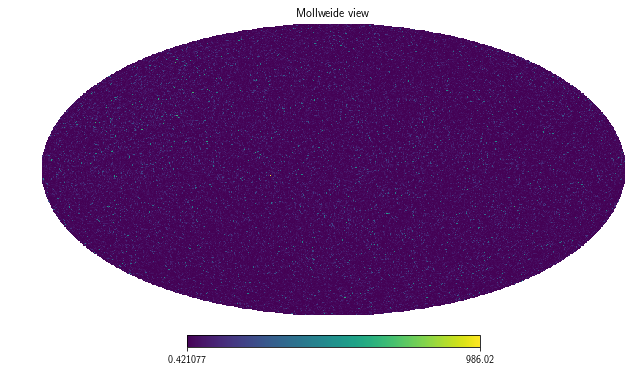

In [56]:
hp.mollview(tot*fermi_exposure)

In [1]:
import re
slurmFolder = "/tigress/somalwar/Subhaloes/Subhalos/EnergyBins/slurm/"
xsec_test_arr = np.logspace(-23, -15, 25)
eBins = [ 10, 15, 20, 40]
nBins = len(eBins)
arrTot_arr_xsec = [[] for i in range(nBins)]
xsec_arr = [[] for i in range(nBins)]
SCD_arr = [[] for i in range(nBins)]
for iB in range(nBins-1):
    print('------------------------',iB,'---------------------')
    n = 0
    arrTot = []
    for t in range(100):
        try:
            file = "slurm_blazSCD_"+str(int(t))+".out"
            nextLine = False
            success = False
            array = []
            strArray = ""
            numBestFit = 0
            for line in open(slurmFolder+file):
                line = line.rstrip()
                if "successfully" in line: success = True
                if "array" in line or nextLine:
                    if "array" in line: numBestFit+=1
                    if "The" in line: 
                        nextLine = False
                        continue
                    else: nextLine = True
                    strArray += line
            array.extend(re.findall("[-+]?[.]?[\d]+(?:,\d\d\d)*[\.]?\d*(?:[eE][-+]?\d+)?", strArray.split("array")[iB+1]))
            if len(array) != 6: 
                continue
            for i in range(len(array)):
                array[i] = float(array[i])
            if success:
                arrTot.append(np.array(array))
                n+=1
            else:
                n+=0
        except:
            n+=0
    A_vals = []
    for i in arrTot:
        A_vals.append(10**i[0])
    arrTot_arr_xsec.append( arrTot )
    print("np.array([",np.log10(np.median(A_vals)), ", ", np.median(arrTot, axis=0)[1], ",", np.median(arrTot, axis=0)[2], ",", np.median(arrTot, axis=0)[3], ",", np.median(arrTot, axis=0)[4], ",", np.median(arrTot, axis=0)[5], "]),")

NameError: name 'np' is not defined